<a href="https://colab.research.google.com/github/ni414/notebook/blob/master/Guide_to_Quantus_An_Explainable_AI_Toolkit_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installing dependencies
! pip install quantus
! pip install captum

     |████████████████████████████████| 89 kB 2.9 MB/s 
     |████████████████████████████████| 22.3 MB 83.9 MB/s 
     |████████████████████████████████| 25.9 MB 2.2 MB/s 
     |████████████████████████████████| 11.5 MB 27.6 MB/s 
     |████████████████████████████████| 13.3 MB 44.0 MB/s 
     |████████████████████████████████| 280 kB 42.4 MB/s 
     |████████████████████████████████| 60.4 MB 29 kB/s 
     |████████████████████████████████| 14.8 MB 39.3 MB/s 
     |████████████████████████████████| 213 kB 58.7 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 69 kB 7.4 MB/s 
     |████████████████████████████████| 42 kB 872 kB/s 
     |████████████████████████████████| 207 kB 54.6 MB/s 
     |████████████████████████████████| 207 kB 55.4 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.0
    Uninstalling importlib-metadata-4.11.0:
      Successfully uninstalled importlib-metada

     |████████████████████████████████| 1.4 MB 4.0 MB/s 


In [ ]:
! git clone https://github.com/understandable-machine-intelligence-lab/Quantus.git

Cloning into 'Quantus'...
remote: Enumerating objects: 7620, done.
remote: Counting objects: 100% (7620/7620), done.
remote: Compressing objects: 100% (1778/1778), done.
remote: Total 7620 (delta 6687), reused 6519 (delta 5790), pack-reused 0
Receiving objects: 100% (7620/7620), 136.66 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (6687/6687), done.


In [ ]:
import quantus
import torch
import torchvision
from torchvision import transforms
# load the model from repo
from Quantus.quantus.helpers.models import LeNet
import captum
from captum.attr import *
import pandas as pd
import numpy as np

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
# load the model
model = LeNet()
model.load_state_dict(torch.load("Quantus/tutorials/assets/mnist", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# load the data
transformer = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



In [ ]:
# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [ ]:
a_batch_saliency = quantus.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
a_batch_intgrad = quantus.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()


# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_saliency, a_batch_intgrad]]

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
import matplotlib.pyplot as plt

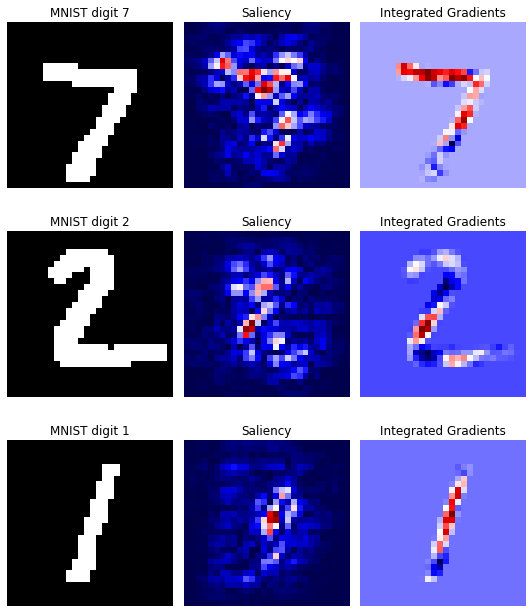

In [ ]:
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a_batch_saliency[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Saliency")
    axes[i, 1].axis("off")
    a = axes[i, 2].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 2].title.set_text(f"Integrated Gradients")
    axes[i, 2].axis("off")
#plt.savefig(f'{path}/quantus/tutorials/assets/mnist_example.png', dpi=400)
plt.tight_layout()
plt.show()

## Evaluating using Quantus

In [ ]:
# Define params for evaluation.
params_eval = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
    "disable_warnings": True}

In [ ]:
scores_saliency = quantus.MaxSensitivity(**params_eval)(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_saliency,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device, "img_size": 28, "normalise": False, "abs": False})

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
scores_intgrad = quantus.MaxSensitivity(**params_eval)(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device, "img_size": 28, "normalise": False, "abs": False})

In [ ]:
print(f"max-Sensitivity scores\n" \
      f"\n • Saliency = {np.mean(scores_saliency):.2f} ({np.std(scores_saliency):.2f})." \
      f"\n • Integrated Gradients = {np.mean(scores_intgrad):.2f} ({np.std(scores_intgrad):.2f})."
      )

max-Sensitivity scores

 • Saliency = 0.74 (0.21).
 • Integrated Gradients = 0.28 (0.07).
